In [1]:
%run ../../src/start.py


python	3.9.6 (default, Jul 30 2021, 16:35:19) 
[GCC 7.5.0]
---------------------
Versions:
----------------------
pandas      1.3.1
numpy       1.20.3
matplotlib  3.4.2
seaborn     0.11.1
plotly      5.1.0
boto3       1.18.16
awswrangler 2.10.0
----------------------


Loaded Libraries
-------------------
import pandas as pd
import numpy as np
import sys,os
import re
import glob
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import plotly
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)


## AWS
import boto3
import awswrangler as wr
----------------


GLOBAL VARIABLES
--------------------------
# Creating the low level functional client
client = boto3.client(
    's3',
    aws_access_key_id = AWS_KEY_ID,
    aws_secret_access_key = AWS_SECRET,
)
    
# Creating the high level object oriented interface
resource = boto3.resource(
    's3',
    aws_access_key_id = AWS_KEY_I

## Load Data

In [2]:
# year file
year = '2015'

In [3]:
# helper function
def bucket_raw_path(bucket_name,path_dir):
    ''''''
    raw_path = f's3://{bucket_name}/{path_dir}'
    return raw_path

In [4]:
raw = bucket_raw_path('dend-data',f'capstone/raw-data/crime-data/{year}')
raw

's3://dend-data/capstone/raw-data/crime-data/2015'

## List objects in bucket

In [5]:
wr.s3.list_objects(raw)

['s3://dend-data/capstone/raw-data/crime-data/2015/apr15.xlsx',
 's3://dend-data/capstone/raw-data/crime-data/2015/aug15.xlsx',
 's3://dend-data/capstone/raw-data/crime-data/2015/dec15.xlsx',
 's3://dend-data/capstone/raw-data/crime-data/2015/feb15.xlsx',
 's3://dend-data/capstone/raw-data/crime-data/2015/jan15.xlsx',
 's3://dend-data/capstone/raw-data/crime-data/2015/jul15.xlsx',
 's3://dend-data/capstone/raw-data/crime-data/2015/jun15.xlsx',
 's3://dend-data/capstone/raw-data/crime-data/2015/mar15.xlsx',
 's3://dend-data/capstone/raw-data/crime-data/2015/may15.xlsx',
 's3://dend-data/capstone/raw-data/crime-data/2015/nov15.xlsx',
 's3://dend-data/capstone/raw-data/crime-data/2015/oct15.xlsx',
 's3://dend-data/capstone/raw-data/crime-data/2015/sep15.xlsx']

## Create dataframe from s3 files

In [6]:
def s3_files_to_df(s3_files_path):
    ''' load s3 file path from wr result
    returns a dataframe of concat files '''
    df_list = []
    for i in wr.s3.list_objects(s3_files_path):
        temp = wr.s3.read_excel(i, engine='openpyxl')
        df_list.append(temp)
    # create df from list files
    df = pd.concat(df_list, ignore_index=True)
    return df

In [7]:
%%time
df = s3_files_to_df(raw)

CPU times: user 48.8 s, sys: 297 ms, total: 49.1 s
Wall time: 1min 2s


In [8]:
## cleanup columns
df.columns = df.columns.str.lower().str.replace(' ','_').str.replace('\n','_').str.strip()

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120009 entries, 0 to 120008
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   date          120009 non-null  datetime64[ns]
 1   hour          120009 non-null  int64         
 2   offense_type  120009 non-null  object        
 3   beat          120009 non-null  object        
 4   premise       117881 non-null  object        
 5   blockrange    120009 non-null  object        
 6   streetname    120009 non-null  object        
 7   type          120009 non-null  object        
 8   suffix        120009 non-null  object        
 9   ._offenses    120009 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(7)
memory usage: 9.2+ MB


In [10]:
df.head()

,date,hour,offense_type,beat,premise,blockrange,streetname,type,suffix,._offenses
0,2015-02-26,12,Theft,10H10,"Road, Street, or Sidewalk",4900-4999,CANAL,ST,-,1
1,2015-04-05,16,Burglary,10H10,Residence or House,100-199,YORK,-,-,1
2,2015-04-06,20,Rape,10H10,Residence or House,UNK,CANAL,CT,-,1
3,2015-04-16,8,Theft,10H10,Construction Site,400-499,ENNIS,ST,-,1
4,2015-04-01,19,Theft,10H10,NaN,UNK,SIDNEY,-,-,1


## Show null data

In [11]:
df.apply(lambda x: sum(x.isnull()))

date               0
hour               0
offense_type       0
beat               0
premise         2128
blockrange         0
streetname         0
type               0
suffix             0
._offenses         0
dtype: int64

In [12]:
# create null percentage of column as dataframe
null_per_df = pd.DataFrame(df.isna().mean().round(4) * 100)
# rename columns
null_per_df.rename(columns={'index': 'col_name', 0: 'null_percent'}, inplace=True)

# filter data <20% null values
per_filter = null_per_df.null_percent<=90
null_per_df[per_filter].sort_values(by='null_percent',ascending=False)

,null_percent
premise,1.77
date,0.00
hour,0.00
offense_type,0.00
beat,0.00
blockrange,0.00
streetname,0.00
type,0.00
suffix,0.00
._offenses,0.00


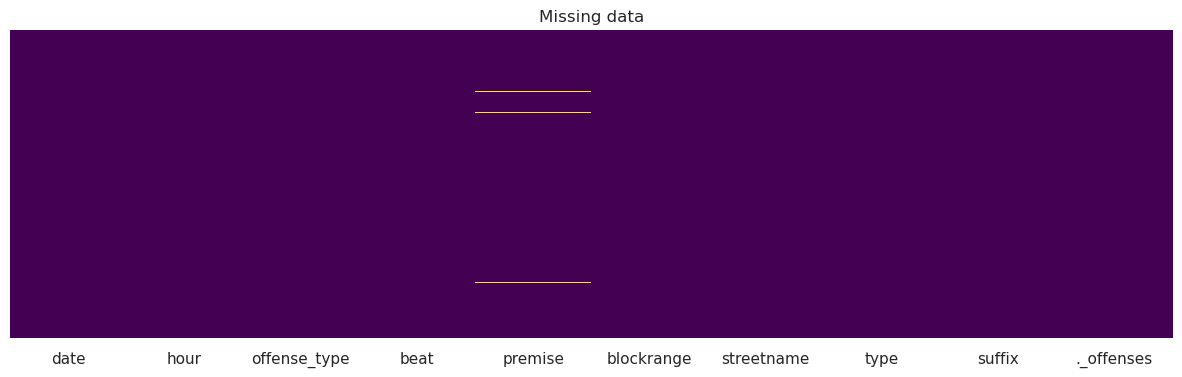

In [13]:
plt.figure(figsize=(15,4))
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')
plt.title('Missing data')
plt.show()

## Change column name

In [14]:
df.rename(columns={
    '._offenses': 'offenses',
}, inplace=True)

df.rename(columns={'blockrange': 'block_range', 'streetname': 'street_name'}, inplace=True)


## Fix missing data

In [15]:
df[df.premise.isna()]

,date,hour,offense_type,beat,premise,block_range,street_name,type,suffix,offenses
4,2015-04-01,19,Theft,10H10,NaN,UNK,SIDNEY,-,-,1
14,2009-05-18,11,Theft,10H10,NaN,4500-4599,CANAL,ST,-,1
27,2015-04-21,13,Theft,10H10,NaN,3300-3399,NAVIGATION,-,-,1
39,2015-04-02,0,Burglary,10H20,NaN,3800-3899,LAMAR,-,-,1
56,2015-04-07,14,Theft,10H20,NaN,4300-4399,COYLE,ST,-,1
...,...,...,...,...,...,...,...,...,...,...
119838,2014-09-30,4,Rape,9C40,NaN,13100-13199,EAST,FWY,-,1
119846,2015-09-24,5,Burglary,9C40,NaN,1200-1299,FEDERAL,RD,-,1
119885,2015-09-18,16,Theft,9C40,NaN,12400-12499,EAST,FWY,-,1
119909,2015-09-18,21,Auto Theft,9C40,NaN,12600-12699,IH 10,-,E,1


In [16]:
## Change null values to UNK

df["premise"].fillna("UNK", inplace = True)

In [17]:
df.apply(lambda x: sum(x.isnull()))

date            0
hour            0
offense_type    0
beat            0
premise         0
block_range     0
street_name     0
type            0
suffix          0
offenses        0
dtype: int64

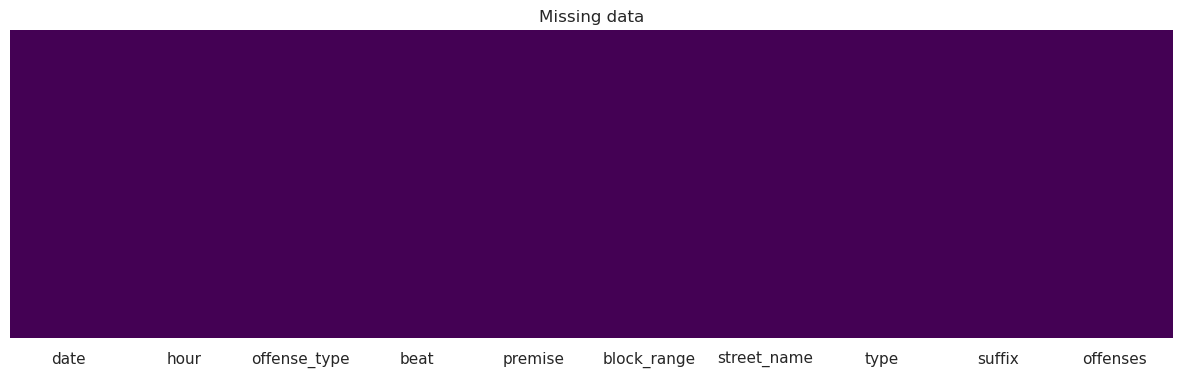

In [18]:
plt.figure(figsize=(15,4))
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')
plt.title('Missing data')
plt.show()

## Combine columns 

## Combine date & hour to one column

In [19]:
# convert two columns into one datetime
df['date_time'] = pd.to_datetime(df['date']) + pd.to_timedelta(df['hour'], unit='h')

# # drop columns
# df = df.drop(['date','hour'], axis = 1)

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120009 entries, 0 to 120008
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   date          120009 non-null  datetime64[ns]
 1   hour          120009 non-null  int64         
 2   offense_type  120009 non-null  object        
 3   beat          120009 non-null  object        
 4   premise       120009 non-null  object        
 5   block_range   120009 non-null  object        
 6   street_name   120009 non-null  object        
 7   type          120009 non-null  object        
 8   suffix        120009 non-null  object        
 9   offenses      120009 non-null  int64         
 10  date_time     120009 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(7)
memory usage: 10.1+ MB


In [21]:
df.head()

,date,hour,offense_type,beat,premise,block_range,street_name,type,suffix,offenses,date_time
0,2015-02-26,12,Theft,10H10,"Road, Street, or Sidewalk",4900-4999,CANAL,ST,-,1,2015-02-26 12:00:00
1,2015-04-05,16,Burglary,10H10,Residence or House,100-199,YORK,-,-,1,2015-04-05 16:00:00
2,2015-04-06,20,Rape,10H10,Residence or House,UNK,CANAL,CT,-,1,2015-04-06 20:00:00
3,2015-04-16,8,Theft,10H10,Construction Site,400-499,ENNIS,ST,-,1,2015-04-16 08:00:00
4,2015-04-01,19,Theft,10H10,UNK,UNK,SIDNEY,-,-,1,2015-04-01 19:00:00


## Convert offenses to integer

In [22]:
# convert offenses to int
df['offenses'] = df['offenses'].astype('int64')

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120009 entries, 0 to 120008
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   date          120009 non-null  datetime64[ns]
 1   hour          120009 non-null  int64         
 2   offense_type  120009 non-null  object        
 3   beat          120009 non-null  object        
 4   premise       120009 non-null  object        
 5   block_range   120009 non-null  object        
 6   street_name   120009 non-null  object        
 7   type          120009 non-null  object        
 8   suffix        120009 non-null  object        
 9   offenses      120009 non-null  int64         
 10  date_time     120009 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(7)
memory usage: 10.1+ MB


# Create year column

In [24]:
df['year'] = 2015
df.head()

,date,hour,offense_type,beat,premise,block_range,street_name,type,suffix,offenses,date_time,year
0,2015-02-26,12,Theft,10H10,"Road, Street, or Sidewalk",4900-4999,CANAL,ST,-,1,2015-02-26 12:00:00,2015
1,2015-04-05,16,Burglary,10H10,Residence or House,100-199,YORK,-,-,1,2015-04-05 16:00:00,2015
2,2015-04-06,20,Rape,10H10,Residence or House,UNK,CANAL,CT,-,1,2015-04-06 20:00:00,2015
3,2015-04-16,8,Theft,10H10,Construction Site,400-499,ENNIS,ST,-,1,2015-04-16 08:00:00,2015
4,2015-04-01,19,Theft,10H10,UNK,UNK,SIDNEY,-,-,1,2015-04-01 19:00:00,2015


## change order of columns

In [25]:
col_ord =['date_time','offenses','offense_type', 'block_range', 'street_name', 'type', 'suffix','beat', 'premise','date','hour','year']
df = df[col_ord]
df.head()

,date_time,offenses,offense_type,block_range,street_name,type,suffix,beat,premise,date,hour,year
0,2015-02-26 12:00:00,1,Theft,4900-4999,CANAL,ST,-,10H10,"Road, Street, or Sidewalk",2015-02-26,12,2015
1,2015-04-05 16:00:00,1,Burglary,100-199,YORK,-,-,10H10,Residence or House,2015-04-05,16,2015
2,2015-04-06 20:00:00,1,Rape,UNK,CANAL,CT,-,10H10,Residence or House,2015-04-06,20,2015
3,2015-04-16 08:00:00,1,Theft,400-499,ENNIS,ST,-,10H10,Construction Site,2015-04-16,8,2015
4,2015-04-01 19:00:00,1,Theft,UNK,SIDNEY,-,-,10H10,UNK,2015-04-01,19,2015


In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120009 entries, 0 to 120008
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   date_time     120009 non-null  datetime64[ns]
 1   offenses      120009 non-null  int64         
 2   offense_type  120009 non-null  object        
 3   block_range   120009 non-null  object        
 4   street_name   120009 non-null  object        
 5   type          120009 non-null  object        
 6   suffix        120009 non-null  object        
 7   beat          120009 non-null  object        
 8   premise       120009 non-null  object        
 9   date          120009 non-null  datetime64[ns]
 10  hour          120009 non-null  int64         
 11  year          120009 non-null  int64         
dtypes: datetime64[ns](2), int64(3), object(7)
memory usage: 11.0+ MB


In [30]:
df.loc[df.duplicated(keep='first'),:]

,date_time,offenses,offense_type,block_range,street_name,type,suffix,beat,premise,date,hour,year
24965,2015-08-13 20:00:00,1,Theft,9600-9699,WESTHEIMER,RD,-,18F40,Grocery Store or Supermarket,2015-08-13,20,2015
25438,2015-08-28 23:00:00,1,Theft,10900-10999,BEECHNUT,ST,-,19G10,Convenience Store,2015-08-28,23,2015
25440,2015-08-26 17:00:00,1,Theft,9800-9899,BEECHNUT,ST,-,19G10,Service or Gas Station,2015-08-26,17,2015
30210,2015-08-20 09:00:00,1,Robbery,300-399,SAM HOUSTON,PKWY,-,6B50,Restaurant or Cafeteria Parking Lot,2015-08-20,9,2015
34511,2015-02-21 18:00:00,1,Theft,5100-5199,ALABAMA,ST,W,18F20,Clothing Store,2015-02-21,18,2015
35793,2015-02-26 10:00:00,1,Theft,2000-2099,WESTHEIMER,RD,-,1A30,Grocery Store or Supermarket,2015-02-26,10,2015
37374,2015-02-17 12:00:00,1,Theft,700-799,CROSSTIMBERS,ST,-,3B50,Drug Store or Medical Supply,2015-02-17,12,2015
38108,2015-02-20 10:00:00,1,Theft,7100-7199,NORDLING,RD,-,6B10,"Other, Unknown, or Not Listed",2015-02-20,10,2015
39210,2015-02-25 10:00:00,1,Theft,8700-8799,COWART,ST,-,9C10,Residence or House,2015-02-25,10,2015
39482,2015-01-05 01:00:00,1,Burglary,6200-6299,INDUSTRIAL,WAY,-,10H10,Residence or House,2015-01-05,1,2015


In [31]:
df.drop_duplicates(keep='first',inplace=True)

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119941 entries, 0 to 120008
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   date_time     119941 non-null  datetime64[ns]
 1   offenses      119941 non-null  int64         
 2   offense_type  119941 non-null  object        
 3   block_range   119941 non-null  object        
 4   street_name   119941 non-null  object        
 5   type          119941 non-null  object        
 6   suffix        119941 non-null  object        
 7   beat          119941 non-null  object        
 8   premise       119941 non-null  object        
 9   date          119941 non-null  datetime64[ns]
 10  hour          119941 non-null  int64         
 11  year          119941 non-null  int64         
dtypes: datetime64[ns](2), int64(3), object(7)
memory usage: 11.9+ MB


## Save to bucket

In [33]:
bucket = 'dend-data'
file_name = f'crime_{year}.csv'
path_to_save = f"s3://{bucket}/capstone/inter-data/crime-data/{file_name}"
path_to_save

's3://dend-data/capstone/inter-data/crime-data/crime_2015.csv'

In [34]:
%%time
wr.s3.to_csv(df, path_to_save, index=False)

CPU times: user 1.16 s, sys: 51.4 ms, total: 1.21 s
Wall time: 21 s


{'paths': ['s3://dend-data/capstone/inter-data/crime-data/crime_2015.csv'],
 'partitions_values': {}}

# Save Sample

In [35]:
%%time
sample_100 = df.sample(100)


bucket = 'dend-data'
file_name = f'crime_{year}.csv'
path_to_save = f"s3://{bucket}/capstone/sample-data/crime-data/{file_name}"

wr.s3.to_csv(sample_100, path_to_save, index=False)

CPU times: user 26.1 ms, sys: 79 µs, total: 26.2 ms
Wall time: 360 ms


{'paths': ['s3://dend-data/capstone/sample-data/crime-data/crime_2015.csv'],
 'partitions_values': {}}